# Analysis of Bathymetric Data
This script was written for a different sensor that also used the Adafruit GPS Featherwing and therefore uses a very similar data format. In particular, we'll need it for parsing the GPS lat/lon data. Code chunk under "Read in data, rename columns, simple pre-processing" will have especially useful tidbits but all will need to be modified for our purposes.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import datetime

### TODO:
Don't imagine Plotly will work. Convert to Cartopy for static maps for now.

In [2]:
import plotly
import plotly.graph_objs as go
mapbox_access_token = os.environ['MY_MAPBOX_KEY']

### Read in data, rename columns, simple pre-processing

In [3]:
# filename = '21052401_Baldhead_truncate_flight1.CSV'
filename = '22061700.CSV'
filepath = os.path.join('Data', filename)
df = pd.read_csv(filepath, parse_dates = [[0, 1]], header = None)
df.columns = ['time', 'elapsed time (sec)', 'lat_raw', 'N or S', 'lon_raw', 'E or W', 'CO2 (ppm)']

# df = df[100:-30] # TODO: replace with a filter for altitude or motion

# GPS spits out lat DDMM.MMMM, lon DDDMM.MMMM, so additional processing required
def lat_convert(lat_badfmt):
    lat_badfmt = str(lat_badfmt)
    lat_DD = int(float(lat_badfmt)/100) # get DDD part
    lat_MM = float(lat_badfmt)-lat_DD*100 # get MM.MMM part
    lat_deg = float(lat_DD)+float(lat_MM)/60 # add minutes divided by 60 to degrees
    return lat_deg

def lon_convert(lon_badfmt):
    lon_badfmt = str(lon_badfmt)
    lon_DD = int(float(lon_badfmt)/100) # get DDD part
    lon_MM = float(lon_badfmt)-lon_DD*100 # get MM.MMM part
    lon_deg = float(lon_DD)+float(lon_MM)/60 # add minutes divided by 60 to degrees
    return lon_deg

# Do the conversion on real data
df['lat'] = df['lat_raw'].apply(lat_convert)
df['lon'] = df['lon_raw'].apply(lon_convert)

# South should be negative
south = df['N or S'] == 'S'
df['lat'][south] *= -1 

# West should be negative
west = df['E or W'] == 'W'
df['lon'][west] *= -1 

# Take a look
df.head()

<ipython-input-3-2b1f2e21b33b>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lat'][south] *= -1
<ipython-input-3-2b1f2e21b33b>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lon'][west] *= -1


,time,elapsed time (sec),lat_raw,N or S,lon_raw,E or W,CO2 (ppm),lat,lon
0,2022-06-17 10:47:42,5,3405.3792,N,7753.6294,W,1584,34.089653,-77.893823
1,2022-06-17 10:47:44,7,3405.3760,N,7753.6333,W,1604,34.089600,-77.893888
2,2022-06-17 10:47:46,9,3405.3740,N,7753.6362,W,1615,34.089567,-77.893937
3,2022-06-17 10:47:48,11,3405.3755,N,7753.6357,W,1607,34.089592,-77.893928
4,2022-06-17 10:47:50,13,3405.3801,N,7753.6343,W,1557,34.089668,-77.893905


### Plot time-series

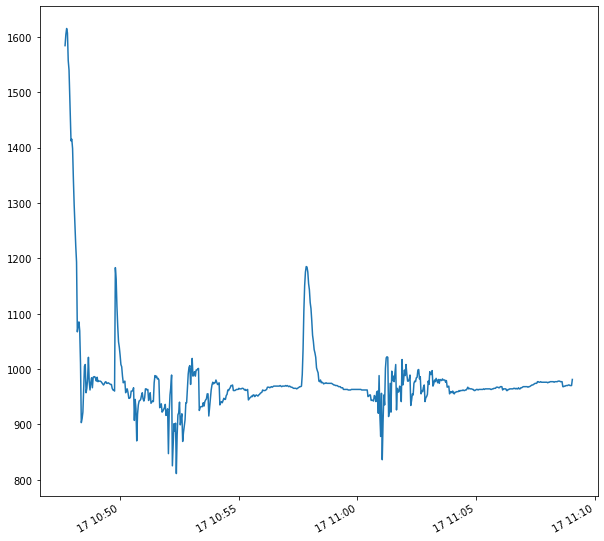

In [4]:
fig, axs = plt.subplots(figsize = (10, 10))
axs.plot(df['time'], df['CO2 (ppm)'])
fig.autofmt_xdate()

### Plot lat in order to estimate when UAS was grounded

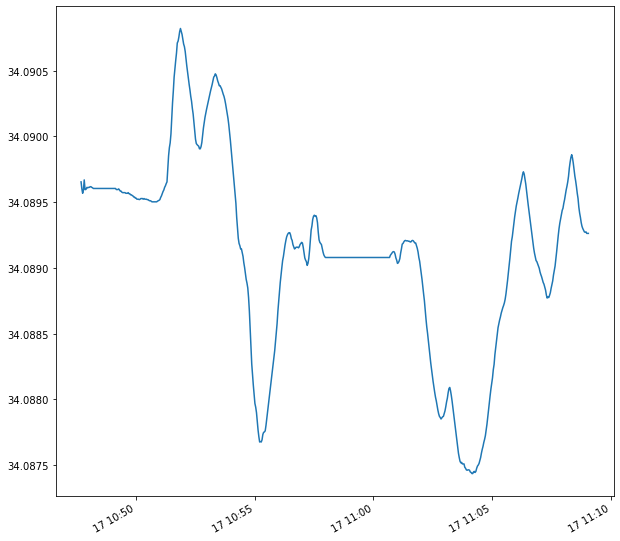

In [5]:
fig, axs = plt.subplots(figsize = (10, 10))
axs.plot(df['time'], df['lat'])
fig.autofmt_xdate()

### Plot spatial data

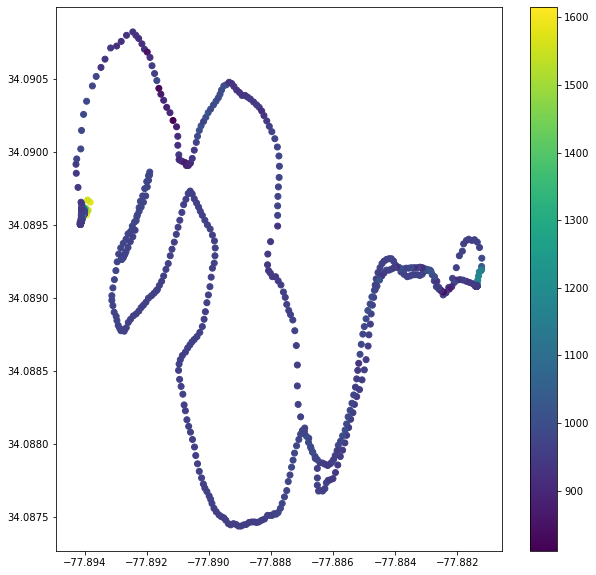

In [6]:
fig, axs = plt.subplots(figsize = (10, 10))
m = axs.scatter(df['lon'], df['lat'], c = df['CO2 (ppm)'])
fig.colorbar(m)

### Put on plotly to get good basemap

In [7]:
# Variables of interest
# df['lon'], df['lat'], c = df['CO2 (ppm)']
lat = df['lat']
lon = df['lon']
co2 = df['CO2 (ppm)']
plot_var_min = 900
plot_var_max = 1050

#use the mean lat/lon to center the map
center_map = (lat.mean(), lon.mean())
size = 50

data = [
   # Smartfin data outlines
   go.Scattermapbox(
       lat=lat,
       lon=lon,
       mode='markers',
       showlegend = False,
       marker=dict(
           size=size,
           color='black',
           opacity=0.8
       ),
       hoverinfo='none'
   ),

   # Smartfin data
   go.Scattermapbox(
       lat=lat,
       lon=lon,
       mode='markers',
       showlegend = True,
       name = 'Temperature (°C)',
       marker=dict(
           size=size-3,
           color=co2,
           colorscale = 'Viridis',
           cmin = plot_var_min,
           cmax = plot_var_max,
           showscale = True,
           opacity=0.8
       ),
       text=co2,
       hoverinfo='text'
   ),

]

layout = go.Layout(
   title='Drone CO2 (ppm), Flight 1',
   autosize=True,
   hovermode='closest',
   showlegend = False,
   mapbox=dict(
       accesstoken=mapbox_access_token,
       bearing=0,
       center=dict(
           lat=center_map[0],
           lon=center_map[1]
       ),
       pitch=0,
       zoom=9,
       style='satellite'
   ),
   margin = go.layout.Margin(
       l = 0,
       r = 20,
       b = 20,
       t = 30,
       pad=4
   )
)

fig = dict(data=data, layout=layout)
figname = 'Figures/interact_'+str(datetime.datetime.now().date())
htmlname = figname+'.html'
plot_url = plotly.offline.plot(fig, filename=htmlname)

In [8]:
df.describe()

,elapsed time (sec),lat_raw,lon_raw,CO2 (ppm),lat,lon
count,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000
mean,645.000000,3405.347568,7753.297764,979.737910,34.089126,-77.888296
std,370.370085,0.045047,0.272632,82.948157,0.000751,0.004544
min,5.000000,3405.246100,7752.872600,811.000000,34.087435,-77.894278
25%,325.000000,3405.333300,7753.056600,961.000000,34.088888,-77.892465
50%,645.000000,3405.349400,7753.340800,966.000000,34.089157,-77.889013
75%,965.000000,3405.375500,7753.547900,977.000000,34.089592,-77.884277
max,1285.000000,3405.449200,7753.656700,1615.000000,34.090820,-77.881210
